## 데이터 파일 읽기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore") # 불필요한 warning 제거

sub_dir = '/content/drive/MyDrive/데이콘/2. 상점 신용카드 매출 예측'

In [4]:
resampling_data = pd.read_csv(sub_dir + '/resampling_data.csv')

resampling_data.head()

,store_id,year_month,amount
0,0,2016-06,7.470000e+05
1,0,2016-07,1.005000e+06
2,0,2016-08,8.697143e+05
3,0,2016-09,8.978571e+05
4,0,2016-10,8.354286e+05


## R 시계열 패키지 forecast를 통한 모델링
forecast : 다양한 시계열 모델링 기능을 제공하는 패키지  
forecastHybrid : 시계열 모델을 쉽게 앙상블 예측하는 기능을 제공하는 패키지

In [6]:
from rpy2.robjects.packages import importr

In [7]:
utils = importr('utils') # utils 패키지를 임포트
utils.install_packages('forecast') # r의 forecast 패키지 설치
utils.install_packages('forecastHybrid') # r의 forecastHybrid 패키지 설치

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘quantmod’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘urca’, ‘zoo’, ‘RcppArmadillo’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/xts_0.12.1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 517875 bytes (505 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =


<rpy2.rinterface_lib.sexp.NULLType object at 0x7f772e930dc0> [RTYPES.NILSXP]

In [10]:
import rpy2.robjects as robjects # r 함수를 파이썬에서 사용 가능하게 변환하는 모듈 -> robjects의 r() 함수가 그 기능을 제공
from rpy2.robjects import pandas2ri # 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈

# pandas2ri를 활성화 
pandas2ri.activate()

r의 forcast 패키지를 이용해 store_id가 0인 상점에 대해 ARIMA 모델로 예측값을 생성

In [17]:
auto_arima = """
  function(ts){
    library(forecast) # forecast 패키지 로드
    d_params = ndiffs(ts) # 시계열 자료의 차분 횟수 계산
    model = auto.arima(ts, max.p=2, d=d_params) # auto.arima 모델 생성
    forecasted_data = forecast(model, h=3) # 이후 3개월(h=3)을 예측
    out_df = data.frame(forecasted_data$mean) # 예측값을 R의 데이터프레임으로 변환
    colnames(out_df) = c('amount') # amount라는 열로 이름을 지정
    out_df
  }
"""

# r() 함수로 r 자료형을 파이썬에서 사용 가능
auto_arima = robjects.r(auto_arima)
ts = robjects.r('ts')# r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수

In [16]:
store_0 = resampling_data[resampling_data['store_id']==0]

start_year = int(min(store_0['year_month'])[:4]) # 영업 시작 년도
start_month = int(min(store_0['year_month'])[5:]) # 영업 시작 월
    
# R의 ts 함수로 r의 time series 자료형으로 변환
# ts 함수의 start 인자에는 영업 시작 년도와 월을 r의 자료형인 벡터의 형태로 넘겨줌
# frequency인자에는 1년이 12개월이므로 12를 넘겨줌
train = ts(store_0['amount'], start=c(start_year, start_month), frequency=12) 

#ensemble model
# auto_arima 함수는 r의 데이터프레임 자료형으로 예측값을 반환
forecast = auto_arima(train)

# robjects.conversion.rpy2py 함수를 사용해, r 자료형을 파이썬 자료형으로 변환
np.sum(robjects.conversion.rpy2py(forecast).values) # 3개월 매출을 합산

2007226.9729129502

## ARIMA(자기회귀누적이동평균) 모델
AR 모델과 MA 모델을 섞은 모델, I는 차분을 구하는것을 의미  
AR 모델: 자기회귀 모델, 미래 예측에 자기 과거를 사용함  
MA 모델: 이동평균 과정, 현재 시계열 데이터가 과거 잔차들의 가중평균으로 구성됨  
잔차항은 백색잡음을 의미하며, 현재 데이터는 과거 백색잡음의 평균값으로 설명된다는 것  
  
시계열 데이터가 정상성인 경우 주로 적용, 초기 차분 단계를 한번 이상 적용해 비정상성을 제거할 수 있다.

In [29]:
final_pred = []

for i in tqdm(resampling_data.store_id.unique()):
  store = resampling_data[resampling_data['store_id']==i]
  start_year = int(min(store['year_month'])[:4]) ## 영업 시작 년도
  start_month = int(min(store['year_month'])[5:]) ## 영업 시작 월

  # R의 ts 함수로 time series 데이터로 변환
  train = ts(store['amount'], start=c(start_year, start_month), frequency=12) 

  # 자동회귀누적이동평균 model
  forecast = auto_arima(train)

  # 미래 3개월 매출액 총합을 예측해서 상점별로 추가
  final_pred.append(np.sum(robjects.conversion.rpy2py(forecast).values))

  0%|          | 0/1967 [00:00<?, ?it/s]

In [30]:
submission = pd.read_csv(sub_dir + '/submission.csv')
submission['amount'] = final_pred
submission.to_csv('submission_arima.csv', index=False)
submission

,store_id,amount
0,0,2.007227e+06
1,1,2.886210e+05
2,2,1.276695e+06
3,4,2.697649e+06
4,5,6.465429e+05
...,...,...
1962,2132,2.190377e+06
1963,2133,7.414846e+05
1964,2134,9.818183e+04
1965,2135,1.755864e+06


## 지수평활법
단순 지수평활법 : 가장 최근 관측값을 가장 중요하게 생각하고 이전의 모든 관측값은 미래를 예측할 때 아무런 정보도 주지 않는다고 가정, 가장 최근에 관측된 값에 가중치를 더 많이 줌  
a는 평활 매개변수로 가중치가 감소하는 비율은 a를 이용하여 조정함  
  
홀트의 선형추세 기법 : 추세가 있는 데이터를 예측할 수 있게 단순 지수평활법을 확장한 방법  
  
여러 지수평활모델 중 현재 주어진 시계열 데이터에 맞는 모델을 찾는 것은 어려운 작업임  
R의 ets()함수는 시계열 데이터에 대해 AIC 값을 최소로 하는 지수평활 모델을 추정함  
AIC는 주어진 데이터셋에서 통계 모델의 상대적 품질을 나타내고 낮을 수록 좋은 모델이라고 할 수 있다, 모델의 적합도가 높고 파라미터 개수가 작은 모델을 찾을 때 도움이 되는 지표이다.

In [27]:
ets = """
  function(ts){
    library(forecast) # forecast 패키지 로드
    model = ets(ts) # AIC가 낮은 지수평활 모델을 찾음 
    forecasted_data = forecast(model, h=3) # 이후 3개월(h=3)을 예측
    out_df = data.frame(forecasted_data$mean) # 예측값을 R의 데이터프레임으로 변환
    colnames(out_df) = c('amount') # amount라는 열로 이름을 지정
    out_df
  }
"""

ets = robjects.r(ets)# str 형식으로 정의된 ets

In [31]:
final_pred = []

for i in tqdm(resampling_data.store_id.unique()):
  store = resampling_data[resampling_data['store_id']==i]
  start_year = int(min(store['year_month'])[:4]) # 영업 시작 년도
  start_month = int(min(store['year_month'])[5:]) # 영업 시작 월

  # R의 ts 함수로 time series 데이터로 변환
  train = ts(store['amount'], start=c(start_year, start_month), frequency=12) 

  # 지수평활법l
  forecast = ets(train)

  # 3개월 매출을 합산, final_pred에 추가
  final_pred.append(np.sum(robjects.conversion.rpy2py(forecast).values))

  0%|          | 0/1967 [00:00<?, ?it/s]

In [32]:
submission = pd.read_csv(sub_dir + '/submission.csv')
submission['amount'] = final_pred
submission.to_csv('submission_ex.csv', index=False)
submission

,store_id,amount
0,0,2.060501e+06
1,1,2.878790e+05
2,2,1.260318e+06
3,4,2.668637e+06
4,5,7.091162e+05
...,...,...
1962,2132,2.190512e+06
1963,2133,3.488475e+05
1964,2134,4.249576e+05
1965,2135,1.622992e+06


## STL 분해를 적용한 지수평활법
STL(NOT standard template library, Seasonal and Trend Decomposition using Loess)  
시계열 데이터가 가진 시간 주기를 알고 있는 경우 시계열 데이터를 계절성과 추세, 나머지 성분으로 분해해 분석하는 기법  
파이썬의 statsmodels 패키지에서 STL 분해 기능을 제공

ex) store_id 가 0인 데이터  
statsmodels의 seasonal_decompose()함수는 STL 분해 기능을 제공  
첫번째 인자: numpy array 형식의 매출액 데이터  
freq 인자는 1년은 12개월이므로 12

In [34]:
# 상점 신용카드 매출 예측~EDA.ipynb
# 데이터프레임을 Series로 변환하는 함수
def time_series(df, i):
  # 상점별로 데이터를 뽑음
  store = df[df['store_id']==i]

  # 날짜 지정 범위는 영업 시작 월부터 2019년 3월 전까지 영업 마감일 기준
  index = pd.date_range(min(store['year_month']),'2019-03',freq='BM') 

  # 시리즈 객체로 변환
  ts = pd.Series(store['amount'].values,index=index)

  return ts

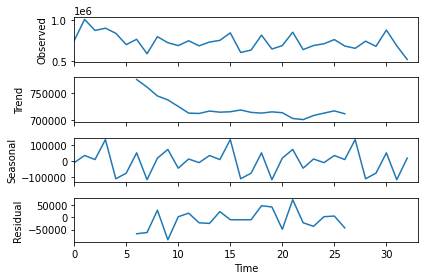

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose

store_0 = time_series(resampling_data, 0)

# STL 분해
stl = seasonal_decompose(store_0.values, freq=12)
stl.plot()
plt.show()

순서대로  
실제 매출액, 추세(Trend), 계절성(Seasonal), 나머지 성분(Residual)로 분해한 것  
  
STL 분해를 적용하고 지수평활법을 통해 예측까지 진행하는 과정은 R의 forecast 패키지의 stlm()함수를 이용하면 편리

In [48]:
stlm = """
  function(ts){
    library(forecast) # forecast 패키지 로드
    model = stlm(ts, s.window="periodic", method='ets') # STL 분해 후 지수평활법을 통한 예측 
    forecasted_data = forecast(model, h=3) # 이후 3개월(h=3)을 예측
    out_df = data.frame(forecasted_data$mean) # 예측값을 R의 데이터프레임으로 변환
    colnames(out_df) = c('amount') # amount라는 열로 이름을 지정
    out_df
  }
"""

# r() 함수로 r을 파이썬에서 사용 가능
stlm = robjects.r(stlm)# str 형식으로 정의된 stlm

In [49]:
final_pred = []

for i in tqdm(resampling_data.store_id.unique()):
  store = resampling_data[resampling_data['store_id']==i]
  
  start_year = int(min(store['year_month'])[:4]) # 영업 시작 년도
  start_month = int(min(store['year_month'])[5:]) # 영업 시작 월

  # R의 ts 함수로 time series 데이터로 변환
  train = ts(store['amount'], start=c(start_year, start_month), frequency=12) 

  # STL 분해를 적용한 지수평활 model
  if len(store) > 24:
    forecast = stlm(train)
  else:   # 지수평활 model
    forecast = ets(train)
  
  # 3개월 매출을 합산, final_pred에 추가
  final_pred.append(np.sum(robjects.conversion.rpy2py(forecast).values))

  0%|          | 0/1967 [00:00<?, ?it/s]

R[write to console]: Error in if (ncol(x) == 1L) { : missing value where TRUE/FALSE needed



RRuntimeError: ignored

# 성능 향상을 위한 방법

## 로그 정규화

In [51]:
# r() 함수로 r 자료형을 파이썬에서 사용 가능
log = robjects.r('log')# 로그 변환 함수
exp = robjects.r('exp')# 로그 역변환 함수

# 0번 상점 추출
store_0 = resampling_data[resampling_data['store_id']==0]
start_year = int(min(store_0['year_month'])[:4])  # 영업 시작 년도
start_month = int(min(store_0['year_month'])[5:]) # 영업 시작 월

# train, test 분리
train = store_0[store_0.index <= len(store_0)-4]  # 2018년 12월 이전
test = store_0[store_0.index > len(store_0)-4]    # 2018년 12월 ~ 2019년 2월

# R의 ts 함수로 r의 time series 자료형으로 변환
train_log = ts(log(train['amount']), start=c(start_year, start_month), frequency=12)  # log 정규화 
train = ts(train['amount'], start=c(start_year, start_month), frequency=12)           # log 정규화를 하지 않음

# model arima
forecast_log = auto_arima(train_log)
forecast = auto_arima(train)

# pred
pred_log = np.sum(robjects.conversion.rpy2py(exp(forecast_log)).values) #로그 역변환 후 3개월 합산
pred = np.sum(robjects.conversion.rpy2py(forecast).values)              #3개월 매출을 합산

# test(2018-12~2019-02)
test = np.sum(test['amount'])

# MAE
print('log-regularization mae: ', abs(test-pred_log))
print('mae:', abs(test-pred))

log-regularization mae:  2401.9663503926713
mae: 5884.674066935433


log regularization을 했을 때 실제 값, test와의 차이가 더 작으므로 성능이 더 우수함을 알 수 있다.  
변동계수란 표준편차를 평균으로 나눈 지표로, 매출액 변동계수가 높은 상점을 로그 정규화 했을 때 예측 성능이 저하되는 것을 발견  
매출액 변동계수가 0.3 미만인 상점만 로그 정규화를 진행해 예측

지수평활법을 이용해 변동계수를 고려해서 로그 정규화를 한 후 예측값을 생성하는 코드

In [52]:
# 매출 변동 계수를 구하는 함수
def coefficient_variation(df, i):
  # 표준편차에서 평균을 나눠 구한 지표
  cv_data = df.groupby(['store_id']).amount.std()/df.groupby(['store_id']).amount.mean()
  cv = cv_data[i]
  return cv

In [53]:
final_pred = []

for i in tqdm(resampling_data.store_id.unique()):
    store = resampling_data[resampling_data['store_id']==i]
    start_year = int(min(store['year_month'])[:4]) # 영업 시작 년도
    start_month = int(min(store['year_month'])[5:]) # 영업 시작 월
    
    cv = coefficient_variation(resampling_data, i)
    
    if cv < 0.3:  # 매출액 변동 계수가 0.3 미만인 경우만 log를 씌움
        train_log = ts(log(store['amount']), start=c(start_year,start_month), frequency=12) 

        # ets model
        forecast_log = ets(train_log)
        final_pred.append(np.sum(robjects.conversion.rpy2py(exp(forecast_log)).values))
    else:         # 매출액 변동 계수가 0.3 이상인 경우
        train = ts(store['amount'], start=c(start_year,start_month), frequency=12)
        
        # 지수평활법
        forecast = ets(train)
        final_pred.append(np.sum(robjects.conversion.rpy2py(forecast).values)) 

  0%|          | 0/1967 [00:00<?, ?it/s]

In [54]:
submission = pd.read_csv('./submission.csv')
submission['amount'] = final_pred
submission.to_csv('submission_log.csv', index=False)
submission

,store_id,amount
0,0,1.963401e+06
1,1,2.483335e+05
2,2,1.260318e+06
3,4,2.660373e+06
4,5,7.091162e+05
...,...,...
1962,2132,2.122653e+06
1963,2133,3.488475e+05
1964,2134,4.249576e+05
1965,2135,1.603989e+06


## R 시계열 패키지 forecastHybrid를 통한 앙상블
ARIMA, 지수평활법, STL 분해를 적용한 지수평활법으로 3개의 예측지를 생성한 다음, 평균값을 통해 최종 매출액을 계산 
앙상블은 여러 모델을 결합해서 예측하는 것으로 과적합을 방지하는 효과가 있다.  
  
R의 forecastHybrid패키지는 시계열 모델에 대한 앙상블을 누구나 손쉽게 할 수 있게 해준다.  
hybridModel()함수가 제공

In [55]:
hybridModel = """
  function(ts){
    library(forecast)
    library(forecastHybrid)
    d_params=ndiffs(ts)
    hb_mdl<-hybridModel(ts, models="aes", # auto_arima, ets, stlm
                    a.arg=list(max.p=2, d=d_params), # auto_arima parameter를 설정하는 인자
                    weight="equal") # 가중치를 동일하게 줌(평균)
    forecasted_data<-forecast(hb_mdl, h=3) # 이후 3개월(h=3)을 예측
    outdf<-data.frame(forecasted_data$mean)
    colnames(outdf)<-c('amount')
    outdf
  }
""" 

# r() 함수로 r 자료형을 파이썬에서 사용 가능
hybridModel = robjects.r(hybridModel)

In [56]:
final_pred = []

for i in tqdm(resampling_data.store_id.unique()):
  store = resampling_data[resampling_data['store_id']==i]
  start_year = int(min(store['year_month'])[:4]) # 영업 시작 년도
  start_month = int(min(store['year_month'])[5:]) # 영업 시작 월
  
  cv = coefficient_variation(resampling_data, i)
  
  if cv < 0.3:    # 매출액 변동 계수가 0.3 미만인 경우만 log를 씌움
    train_log = ts(log(store['amount']), start=c(start_year,start_month), frequency=12) 

    # 앙상블 예측
    forecast_log = hybridModel(train_log)
    final_pred.append(np.sum(robjects.conversion.rpy2py(exp(forecast_log)).values)) 
  else:           # 매출액 변동 계수가 0.3 이상인 경우
    train = ts(store['amount'], start=c(start_year,start_month), frequency=12)
    
    # 앙상블 예측
    forecast = hybridModel(train)
    final_pred.append(np.sum(robjects.conversion.rpy2py(forecast).values))

  0%|          | 0/1967 [00:00<?, ?it/s]

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
R[write to console]: Fitting the auto.arima model

R[write to console]: Fitting the ets model

R[write to console]: Fitting the auto.arima model

R[write to console]: Fitting the ets model

R[write to console]: Fitting the auto.arima model

R[write to console]: Fitting the ets model

R[write to console]: Fitting the auto.arima model

R[write to console]: Fitting the ets model

R[write to console]: Fitting the auto.arima model

R[write to console]: Fitting the ets model

R[write to console]: Fitting the auto.arima model

R[write to console]: Fitting the ets model

R[write to console]: Fitting the auto.arima model

R[write to console]: Fitting the ets model

R[write to console]: Fitting the auto.arima model

R[write to console]: Fitting the ets model

R[write to console]: Fitting the auto.arima model

R[write to console]: Fitting the ets model

R[write to console]: Fitting the auto.arima model

R[write to console]: Fitting the ets model

R[write to con

In [57]:
submission = pd.read_csv('./submission.csv')
submission['amount'] = final_pred
submission.to_csv('submission_hybrid.csv', index=False)
submission

,store_id,amount
0,0,1.999470e+06
1,1,2.628354e+05
2,2,1.268507e+06
3,4,2.665576e+06
4,5,6.778295e+05
...,...,...
1962,2132,2.122726e+06
1963,2133,5.451660e+05
1964,2134,2.615697e+05
1965,2135,1.659767e+06
